<a href="https://colab.research.google.com/github/joseph7104/-1INF46-Plan_Compras_Produccion/blob/master/notebooks/tuning/notebooks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Modelo por Segmento (Plato) — XGBoost
**Fecha:** 2025-11-01 23:17:09

Este notebook entrena **un modelo por plato** para mejorar la precisión (accuracy) aprovechando patrones específicos de cada segmento.

**Estructura:**
1. Imports y Configuración  
2. Carga robusta del dataset + Detección flexible de columnas  
3. Preparación de features y generación opcional de lags/rollings  
4. **Tuning por Segmento** con `RandomizedSearchCV` (compatibilidad sin early-stopping en CV)  
5. **Reentrenamiento Final por Segmento** con early-stopping vía `xgboost.train`  
6. Métricas por segmento + Métrica global (promedio ponderado)  
7. Próximos pasos sugeridos según resultados


In [ ]:

# 1) Imports y Configuración
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import uniform, randint

import xgboost as xgb
from xgboost import XGBRegressor

print("xgboost version:", xgb.__version__)


xgboost version: 3.1.1


In [ ]:
!git clone https://github.com/joseph7104/-1INF46-Plan_Compras_Produccion.git
%cd "./-1INF46-Plan_Compras_Produccion"

Cloning into '-1INF46-Plan_Compras_Produccion'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 117 (delta 26), reused 75 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (117/117), 7.89 MiB | 6.45 MiB/s, done.
Resolving deltas: 100% (26/26), done.
/content/-1INF46-Plan_Compras_Produccion


In [ ]:

# 2) Carga robusta del dataset + Detección flexible de columnas

# Ajusta esta ruta si tu CSV está en otra ubicación.
CANDIDATE_PATHS = [
    Path("data/processed/dataset_forecast_diario.csv"),
    Path("/content/-1INF46-Plan_Compras_Produccion/data/processed/dataset_forecast_diario.csv"),
    Path("/workspace/-1INF46-Plan_Compras_Produccion/data/processed/dataset_forecast_diario.csv"),
]

DATA_PATH = None
for p in CANDIDATE_PATHS:
    if p.exists():
        DATA_PATH = p
        break

print("DATA_PATH encontrado:", DATA_PATH)

assert DATA_PATH is not None, "No se encontró el dataset. Ajusta CANDIDATE_PATHS o define DATA_PATH manualmente."
df = pd.read_csv(DATA_PATH)

DATE_COL_CANDS = ["fecha", "ds", "date", "FECHA"]
TARGET_CANDS    = ["cantidad", "ventas", "ventas_total", "venta_total", "y", "target", "ventas_real"]
PLATO_CANDS     = ["plato", "plato_id", "id_plato", "producto", "categoria"]

CALENDAR_CANDS = {
    "feriado":        ["feriado","is_holiday","es_feriado"],
    "fin_de_semana":  ["fin_de_semana","is_weekend"],
    "dow":            ["dia_semana","dow"],
    "mes":            ["mes","month"],
}

SERIES_CANDS = [
    "lag_1","lag_7","lag_14","lag_21","lag_28",
    "rolling_mean_7","rolling_std_7","rolling_mean_14","rolling_std_14","rolling_mean_28","rolling_std_28"
]

def pick_col(cands, cols_lower):
    for c in cands:
        if c in cols_lower:
            return c
    return None

# normaliza nombres para búsqueda (lower)
cols_lower = [c.lower() for c in df.columns]
colmap = {c.lower(): c for c in df.columns}

date_col   = pick_col(DATE_COL_CANDS, cols_lower)
target_col = pick_col(TARGET_CANDS, cols_lower)
plato_col  = pick_col(PLATO_CANDS, cols_lower)

assert date_col is not None, f"No se detectó columna de fecha. Candidatas: {DATE_COL_CANDS}"
assert target_col is not None, f"No se detectó target (ventas). Candidatas: {TARGET_CANDS}"
assert plato_col is not None, f"No se detectó columna de 'plato' o categoría. Candidatas: {PLATO_CANDS}"

# mapea a nombres originales (case original)
DATE_COL   = colmap[date_col]
TARGET_COL = colmap[target_col]
PLATO_COL  = colmap[plato_col]

calendar_cols = {}
for k, cands in CALENDAR_CANDS.items():
    sel = pick_col(cands, cols_lower)
    if sel is not None:
        calendar_cols[k] = colmap[sel]

series_cols = [colmap[c] for c in SERIES_CANDS if c in cols_lower]

print("Detectado:")
print(" - Fecha      :", DATE_COL)
print(" - Target     :", TARGET_COL)
print(" - Segmento   :", PLATO_COL)
print(" - Calendario :", calendar_cols)
print(" - Series     :", series_cols)

# parse de fecha y orden
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
df = df.sort_values(DATE_COL).reset_index(drop=True)

# Por si hay valores nulos en target, eliminarlos
df = df.dropna(subset=[TARGET_COL])
print("Shape:", df.shape)
df.head(3)


DATA_PATH encontrado: data/processed/dataset_forecast_diario.csv
Detectado:
 - Fecha      : fecha
 - Target     : cantidad
 - Segmento   : plato
 - Calendario : {'feriado': 'feriado', 'fin_de_semana': 'fin_de_semana', 'dow': 'dow', 'mes': 'mes'}
 - Series     : ['lag_1', 'lag_7', 'lag_14', 'lag_28', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14', 'rolling_std_14', 'rolling_mean_28', 'rolling_std_28']
Shape: (21410, 42)


,fecha,plato,cantidad,monto_total,anio,mes,dia,dow,fin_de_semana,feriado,...,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28,dow_sin,dow_cos,mes_sin,mes_cos
0,2021-01-15,1,18.0,468.0,2021,1,15,4,0,0,...,21.428571,5.711309,21.214286,5.937865,NaN,NaN,-0.433884,-0.900969,0.0,1.0
1,2021-01-15,3,17.0,510.0,2021,1,15,4,0,0,...,13.857143,3.804759,13.714286,4.286447,NaN,NaN,-0.433884,-0.900969,0.0,1.0
2,2021-01-15,9,4.0,72.0,2021,1,15,4,0,0,...,3.142857,1.573592,4.000000,2.183857,NaN,NaN,-0.433884,-0.900969,0.0,1.0


In [ ]:

# 3) Preparación de features (lags/rollings si faltan)
NEED_LAGS = any(c not in df.columns for c in ["lag_7", "rolling_mean_7", "rolling_std_7"])

def add_lags_rollings(g, target, lags=[1,7,14,21,28], wins=[7,14,28]):
    g = g.sort_values(DATE_COL).copy()
    for L in lags:
        g[f"lag_{L}"] = g[target].shift(L)
    for W in wins:
        g[f"rolling_mean_{W}"] = g[target].shift(1).rolling(W, min_periods=max(2, W//2)).mean()
        g[f"rolling_std_{W}"]  = g[target].shift(1).rolling(W, min_periods=max(2, W//2)).std()
    return g

if NEED_LAGS:
    print("Generando lags/rollings por segmento…")
    df = df.groupby(PLATO_COL, group_keys=False).apply(lambda g: add_lags_rollings(g, TARGET_COL))

# Definición de features
regressors = []
regressors += list(calendar_cols.values())
regressors += [c for c in series_cols if c in df.columns]

# Limpieza mínima
for c in regressors:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df_model = df.dropna(subset=regressors + [TARGET_COL]).copy()
print("Dataset modelable:", df_model.shape)

seg_counts = df_model.groupby(PLATO_COL)[TARGET_COL].size().sort_values(ascending=False)
print("Top segmentos por cantidad de filas:")
print(seg_counts.head(10))


Dataset modelable: (21242, 42)
Top segmentos por cantidad de filas:
plato
1     1798
2     1798
3     1798
4     1798
5     1798
6     1798
7     1797
8     1794
9     1779
10    1759
Name: cantidad, dtype: int64


In [ ]:
# 4) Utilidades de métrica
def eval_metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    # Calculate RMSE manually as squared=False might not be supported in older sklearn versions
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-6, None))) * 100
    smape= 100*np.mean(2*np.abs(y_true-y_pred)/(np.abs(y_true)+np.abs(y_pred)+1e-6))
    return {"MAE":mae,"RMSE":rmse,"R2":r2,"MAPE":mape,"sMAPE":smape,"Accuracy(1-MAPE)":100-mape}

In [ ]:

# 5) Tuning por Segmento — RandomizedSearchCV (sin early-stopping en CV)
N_SPLITS = 3
tscv = TimeSeriesSplit(n_splits=N_SPLITS)

param_distributions = {
    "n_estimators": randint(350, 900),
    "learning_rate": uniform(0.004, 0.018),
    "max_depth": randint(3, 7),
    "subsample": uniform(0.7, 0.25),
    "colsample_bytree": uniform(0.75, 0.25),
    "gamma": uniform(0.0, 0.3),
    "reg_lambda": uniform(0.7, 1.3),
    "reg_alpha": uniform(0.0, 0.8),
}

base_model = XGBRegressor(
    objective="reg:squarederror",
    tree_method="hist",
    eval_metric="mae",
    random_state=42,
    n_jobs=-1,
)

segmentos = sorted(df_model[PLATO_COL].unique())
print(f"Segmentos detectados: {len(segmentos)} (mostrando primeros 10) ->", segmentos[:10])

# Puedes limitar para pruebas:
# segmentos = segmentos[:10]

best_params_by_segment = {}
cv_mae_by_segment = {}

for seg in segmentos:
    g = df_model[df_model[PLATO_COL] == seg].copy()
    if len(g) < 250:
        continue
    X = g[regressors]
    y = g[TARGET_COL]

    search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_distributions,
        n_iter=30,
        cv=tscv,
        scoring="neg_mean_absolute_error",
        verbose=0,
        random_state=42,
        error_score="raise",
    )
    search.fit(X, y)
    best_params_by_segment[seg] = search.best_params_
    cv_mae_by_segment[seg] = -search.best_score_

print("Tuning finalizado (MAE CV por segmento - top 15):")
print(pd.Series(cv_mae_by_segment).sort_values().head(15))


Segmentos detectados: 12 (mostrando primeros 10) -> [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)]
Tuning finalizado (MAE CV por segmento - top 15):
11    1.323656
12    1.331304
10    1.747611
9     2.131083
8     2.412271
7     2.666064
6     3.141408
5     3.696463
3     4.475043
4     4.634072
2     5.252225
1     5.814923
dtype: float64


In [ ]:

# 6) Reentrenamiento final por segmento con early-stopping (xgboost.train)
results = []
models_store = {}

for seg in segmentos:
    g = df_model[df_model[PLATO_COL] == seg].copy()
    if len(g) < 250 or seg not in best_params_by_segment:
        continue

    X = g[regressors]
    y = g[TARGET_COL].astype(float)

    val_start = int(len(g) * 0.9)
    X_tr, y_tr = X.iloc[:val_start], y.iloc[:val_start]
    X_va, y_va = X.iloc[val_start:], y.iloc[val_start:]

    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dvalid = xgb.DMatrix(X_va, label=y_va)
    dall   = xgb.DMatrix(X,    label=y)

    bp = best_params_by_segment[seg]
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "mae",
        "tree_method": "hist",
        "eta": float(bp["learning_rate"]),
        "max_depth": int(bp["max_depth"]),
        "subsample": float(bp["subsample"]),
        "colsample_bytree": float(bp["colsample_bytree"]),
        "gamma": float(bp["gamma"]),
        "lambda": float(bp["reg_lambda"]),
        "alpha": float(bp["reg_alpha"]),
        "random_state": 42,
    }
    num_boost_round = int(bp["n_estimators"])

    bst = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        evals=[(dvalid, "valid")],
        early_stopping_rounds=40,
        verbose_eval=False
    )

    y_hat_all = bst.predict(dall, iteration_range=(0, bst.best_iteration + 1))
    metrics = eval_metrics(y, y_hat_all)

    row = {"segmento": seg, "n_rows": len(g)}
    row.update(metrics)
    results.append(row)
    models_store[seg] = {"booster": bst, "best_iter": int(bst.best_iteration)}

res_df = pd.DataFrame(results).sort_values("Accuracy(1-MAPE)", ascending=False)
print("Resultados por segmento (top 15 por Accuracy):")
display(res_df.head(15))

# Métrica global ponderada por tamaño de segmento
if not res_df.empty:
    total_n = res_df["n_rows"].sum()
    acc_global = (res_df["Accuracy(1-MAPE)"] * res_df["n_rows"]).sum() / total_n
    mae_global = (res_df["MAE"] * res_df["n_rows"]).sum() / total_n
    rmse_global= (res_df["RMSE"] * res_df["n_rows"]).sum() / total_n
    r2_global  = (res_df["R2"] * res_df["n_rows"]).sum() / total_n
    smape_g    = (res_df["sMAPE"] * res_df["n_rows"]).sum() / total_n

    print("\n=== MÉTRICA GLOBAL (ponderada por segmento) ===")
    print(f"Accuracy global: {acc_global:.2f} %")
    print(f"MAE global     : {mae_global:.4f}")
    print(f"RMSE global    : {rmse_global:.4f}")
    print(f"R2 global      : {r2_global:.4f}")
    print(f"sMAPE global   : {smape_g:.2f} %")
else:
    print("No hay resultados para consolidar.")


Resultados por segmento (top 15 por Accuracy):


,segmento,n_rows,MAE,RMSE,R2,MAPE,sMAPE,Accuracy(1-MAPE)
0,1,1798,5.291241,6.545870,0.241125,24.952743,22.376996,75.047257
1,2,1798,4.849760,5.970983,0.218731,25.676576,22.956296,74.323424
3,4,1798,4.301971,5.325098,0.197658,26.727732,23.391985,73.272268
2,3,1798,4.191788,5.208276,0.152691,30.473491,26.407981,69.526509
4,5,1798,3.479051,4.304184,0.195208,31.634929,26.883797,68.365071
5,6,1798,2.963768,3.720309,0.173585,34.867766,28.384499,65.132234
6,7,1797,2.510707,3.164740,0.106821,44.145335,32.607802,55.854665
7,8,1794,2.289373,2.867844,0.097430,49.497900,35.677122,50.502100
8,9,1779,1.992433,2.497001,0.111041,55.049390,38.099582,44.950610
9,10,1759,1.640062,2.076966,0.066981,60.710257,41.725280,39.289743



=== MÉTRICA GLOBAL (ponderada por segmento) ===
Accuracy global: 57.65 %
MAE global     : 3.0334
RMSE global    : 3.7810
R2 global      : 0.1331
sMAPE global   : 32.24 %


Segmento top: 1.0


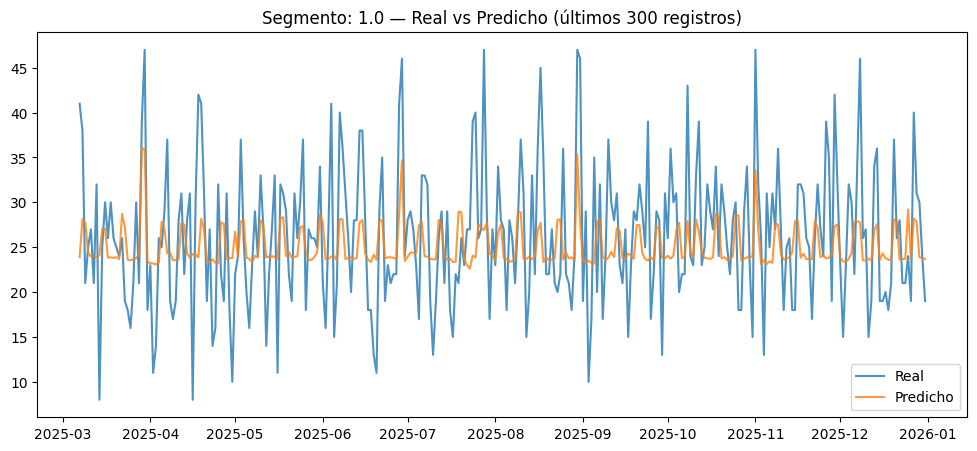

In [ ]:

# 7) Visualización simple del mejor segmento
if 'res_df' in locals() and not res_df.empty:
    top_seg = res_df.iloc[0]["segmento"]
    print("Segmento top:", top_seg)

    g = df_model[df_model[PLATO_COL] == top_seg].copy()
    X_top = g[regressors]
    y_top = g[TARGET_COL].astype(float)
    d_top = xgb.DMatrix(X_top, label=y_top)

    bst = models_store[top_seg]["booster"]
    yhat_top = bst.predict(d_top, iteration_range=(0, bst.best_iteration + 1))

    plt.figure(figsize=(12, 5))
    plt.plot(g[DATE_COL].iloc[-300:], y_top.iloc[-300:], label="Real", alpha=0.8)
    plt.plot(g[DATE_COL].iloc[-300:], yhat_top[-300:], label="Predicho", alpha=0.8)
    plt.title(f"Segmento: {top_seg} — Real vs Predicho (últimos 300 registros)")
    plt.legend()
    plt.show()


In [ ]:

# 8) Guardado de modelos por segmento (booster nativo)
out_dir = Path("models/segmentados_xgb")
out_dir.mkdir(parents=True, exist_ok=True)

saved = []
for seg, obj in models_store.items():
    bst = obj["booster"]
    path = out_dir / f"xgb_{seg}.json"
    bst.save_model(str(path))
    saved.append(str(path))

print("Modelos guardados:", len(saved))
print("\n".join(saved[:10]))


Modelos guardados: 12
models/segmentados_xgb/xgb_1.json
models/segmentados_xgb/xgb_2.json
models/segmentados_xgb/xgb_3.json
models/segmentados_xgb/xgb_4.json
models/segmentados_xgb/xgb_5.json
models/segmentados_xgb/xgb_6.json
models/segmentados_xgb/xgb_7.json
models/segmentados_xgb/xgb_8.json
models/segmentados_xgb/xgb_9.json
models/segmentados_xgb/xgb_10.json



# XGBoost por Segmento — **Mejoras para subir Accuracy**
**Fecha de actualización:** 2025-11-01 01:09:53

Posibles puntos de mejora:

1. **Más features de calendario** (cíclicas y flags de fin de mes/trimestre)
2. **Opcional**: *outlier capping* por segmento (winsorization)
3. Reconstrucción del dataset modelable (`df_model_plus`)
4. **Tuning Poisson** por segmento (`objective="count:poisson"`)
5. Reentrenamiento final con early-stopping y consolidado
6. Comparativa con tus resultados previos (si existe `res_df`)


In [ ]:

# 0) Comprobación de contexto (debe venir del notebook base)
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import uniform, randint

req_vars = ["df_model","DATE_COL","PLATO_COL","TARGET_COL","regressors"]
missing = [v for v in req_vars if v not in globals()]
if missing:
    print("⚠️ Variables faltantes del notebook base:", missing)
    print("Abre y ejecuta primero: xgb_segmentado_por_plato.ipynb")
else:
    print("✅ Contexto OK. Seguimos.")
    print("Columns ahora:", df_model.columns.tolist()[:20], "...")


✅ Contexto OK. Seguimos.
Columns ahora: ['fecha', 'plato', 'cantidad', 'monto_total', 'anio', 'mes', 'dia', 'dow', 'fin_de_semana', 'feriado', 'evento_Ano_Nuevo', 'evento_Viernes_Santo', 'evento_Sabado_Santo', 'evento_Dia_del_Trabajador', 'evento_Dia_del_Pollo_a_la_Brasa', 'evento_San_Pedro_y_San_Pablo', 'evento_Fiestas_Patrias_1', 'evento_Fiestas_Patrias_2', 'evento_Santa_Rosa_de_Lima', 'evento_Combate_de_Angamos'] ...


In [ ]:

# 1) Features de calendario adicionales (con seguridad ante duplicados)
def add_calendar_features(df, date_col):
    d = df.copy()
    d["year"] = d[date_col].dt.year
    d["weekofyear"] = d[date_col].dt.isocalendar().week.astype(int)
    d["dayofyear"] = d[date_col].dt.dayofyear
    d["is_month_end"] = d[date_col].dt.is_month_end.astype(int)
    d["is_month_start"] = d[date_col].dt.is_month_start.astype(int)
    d["is_quarter_end"] = d[date_col].dt.is_quarter_end.astype(int)
    d["is_quarter_start"] = d[date_col].dt.is_quarter_start.astype(int)
    # codificación cíclica de día de la semana y del mes (si no existen)
    if "dia_semana" in d.columns:
        dow = d["dia_semana"].astype(int).values
    elif "dow" in d.columns:
        dow = d["dow"].astype(int).values
    else:
        dow = d[date_col].dt.dayofweek.values
        d["dow"] = dow

    d["dow_sin"] = np.sin(2*np.pi*dow/7.0)
    d["dow_cos"] = np.cos(2*np.pi*dow/7.0)

    if "mes" in d.columns:
        mm = d["mes"].astype(int).values
    elif "month" in d.columns:
        mm = d["month"].astype(int).values
    else:
        mm = d[date_col].dt.month.values
        d["mes"] = mm

    d["mes_sin"] = np.sin(2*np.pi*mm/12.0)
    d["mes_cos"] = np.cos(2*np.pi*mm/12.0)
    return d

df_cal = add_calendar_features(df_model, DATE_COL)

# Extiende lista de regresores con nuevas features
extra_feats = ["year","weekofyear","dayofyear",
               "is_month_end","is_month_start","is_quarter_end","is_quarter_start",
               "dow_sin","dow_cos","mes_sin","mes_cos"]

regressors_plus = list(dict.fromkeys(regressors + [c for c in extra_feats if c in df_cal.columns]))
print("Total features previas:", len(regressors), "| nuevas:", len(regressors_plus))


Total features previas: 14 | nuevas: 25


In [ ]:

# 2) (Opcional) Outlier capping por segmento — quita muucha varianza rara que daña MAPE
USE_CAPPING = True  # cambia a False si quieres desactivarlo
LOW_Q, HIGH_Q = 0.01, 0.99

df_capped = df_cal.copy()
if USE_CAPPING:
    for seg, g in df_capped.groupby(PLATO_COL):
        qlow, qhi = g[TARGET_COL].quantile([LOW_Q, HIGH_Q])
        mask = (df_capped[PLATO_COL] == seg)
        df_capped.loc[mask, TARGET_COL] = np.clip(df_capped.loc[mask, TARGET_COL], qlow, qhi)

print("Capping aplicado:", USE_CAPPING)


Capping aplicado: True


In [ ]:
# 3) Reconstrucción df_model_plus
# Limpieza mínima y eliminación de NA
for c in regressors_plus:
    if c in df_capped.columns:
        df_capped[c] = pd.to_numeric(df_capped[c], errors="coerce")

df_model_plus = df_capped.dropna(subset=regressors_plus + [TARGET_COL]).copy()
print("Dataset modelable (PLUS):", df_model_plus.shape)

# Utilidades
def eval_metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    # Calculate RMSE manually as squared=False might not be supported in older sklearn versions
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-6, None))) * 100
    smape= 100*np.mean(2*np.abs(y_true-y_pred)/(np.abs(y_true)+np.abs(y_pred)+1e-6))
    return {"MAE":mae,"RMSE":rmse,"R2":r2,"MAPE":mape,"sMAPE":smape,"Accuracy(1-MAPE)":100-mape}

Dataset modelable (PLUS): (21242, 49)


In [ ]:

# 4) Tuning por segmento — objective='count:poisson'
N_SPLITS = 3
tscv = TimeSeriesSplit(n_splits=N_SPLITS)

param_distributions = {
    "n_estimators": randint(500, 1200),
    "learning_rate": uniform(0.003, 0.01),
    "max_depth": randint(3, 6),
    "subsample": uniform(0.7, 0.25),
    "colsample_bytree": uniform(0.75, 0.25),
    "gamma": uniform(0.0, 0.25),
    "reg_lambda": uniform(0.7, 1.3),
    "reg_alpha": uniform(0.0, 0.6),
    "min_child_weight": randint(1, 6),
    "max_delta_step": randint(0, 4),  # útil en Poisson
}

base_poisson = XGBRegressor(
    objective="count:poisson",
    tree_method="hist",
    eval_metric="mae",
    random_state=42,
    n_jobs=-1,
)

segmentos = sorted(df_model_plus[PLATO_COL].unique())
print(f"Segmentos detectados: {len(segmentos)} (muestra 10) ->", segmentos[:10])

# Para acelerarlo durante pruebas:
# segmentos = segmentos[:12]

best_params_poisson = {}
cv_mae_poisson = {}

for seg in segmentos:
    g = df_model_plus[df_model_plus[PLATO_COL] == seg].copy()
    if len(g) < 250:
        continue
    X = g[regressors_plus]
    y = g[TARGET_COL]

    search = RandomizedSearchCV(
        estimator=base_poisson,
        param_distributions=param_distributions,
        n_iter=25,  # sube a 40–60 para exprimir
        cv=tscv,
        scoring="neg_mean_absolute_error",
        verbose=0,
        random_state=42,
        error_score="raise",
    )
    search.fit(X, y)
    best_params_poisson[seg] = search.best_params_
    cv_mae_poisson[seg] = -search.best_score_

print("Top 15 segmentos (menor MAE CV) en Poisson:")
import pandas as pd
display(pd.Series(cv_mae_poisson).sort_values().head(15))


Segmentos detectados: 12 (muestra 10) -> [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10)]
Top 15 segmentos (menor MAE CV) en Poisson:


,0
11,1.293038
12,1.307997
10,1.714441
9,2.103274
8,2.377565
7,2.602965
6,3.114651
5,3.675086
3,4.374913
4,4.553497


In [ ]:

# 5) Reentrenamiento final por segmento con early-stopping (Poisson)
results_poisson = []
models_poisson = {}

for seg in segmentos:
    g = df_model_plus[df_model_plus[PLATO_COL] == seg].copy()
    if len(g) < 250 or seg not in best_params_poisson:
        continue

    X = g[regressors_plus]
    y = g[TARGET_COL].astype(float)

    val_start = int(len(g) * 0.9)
    X_tr, y_tr = X.iloc[:val_start], y.iloc[:val_start]
    X_va, y_va = X.iloc[val_start:], y.iloc[val_start:]

    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dvalid = xgb.DMatrix(X_va, label=y_va)
    dall   = xgb.DMatrix(X,    label=y)

    bp = best_params_poisson[seg]
    params = {
        "objective": "count:poisson",
        "eval_metric": "mae",
        "tree_method": "hist",
        "eta": float(bp["learning_rate"]),
        "max_depth": int(bp["max_depth"]),
        "subsample": float(bp["subsample"]),
        "colsample_bytree": float(bp["colsample_bytree"]),
        "gamma": float(bp["gamma"]),
        "lambda": float(bp["reg_lambda"]),
        "alpha": float(bp["reg_alpha"]),
        "min_child_weight": int(bp["min_child_weight"]),
        "max_delta_step": int(bp["max_delta_step"]),
        "random_state": 42,
    }
    num_boost_round = int(bp["n_estimators"])

    bst = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        evals=[(dvalid, "valid")],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    y_hat_all = bst.predict(dall, iteration_range=(0, bst.best_iteration + 1))
    metrics = eval_metrics(y, y_hat_all)

    row = {"segmento": seg, "n_rows": len(g)}
    row.update(metrics)
    results_poisson.append(row)
    models_poisson[seg] = {"booster": bst, "best_iter": int(bst.best_iteration)}

res_poisson_df = pd.DataFrame(results_poisson).sort_values("Accuracy(1-MAPE)", ascending=False)
print("Resultados por segmento (Poisson) — top 15 por Accuracy:")
display(res_poisson_df.head(15))

# Métrica global (ponderada)
if not res_poisson_df.empty:
    total_n = res_poisson_df["n_rows"].sum()
    acc_global = (res_poisson_df["Accuracy(1-MAPE)"] * res_poisson_df["n_rows"]).sum() / total_n
    mae_global = (res_poisson_df["MAE"] * res_poisson_df["n_rows"]).sum() / total_n
    rmse_global= (res_poisson_df["RMSE"] * res_poisson_df["n_rows"]).sum() / total_n
    r2_global  = (res_poisson_df["R2"] * res_poisson_df["n_rows"]).sum() / total_n
    smape_g    = (res_poisson_df["sMAPE"] * res_poisson_df["n_rows"]).sum() / total_n

    print("\n=== MÉTRICA GLOBAL (Poisson, ponderada) ===")
    print(f"Accuracy global: {acc_global:.2f} %")
    print(f"MAE global     : {mae_global:.4f}")
    print(f"RMSE global    : {rmse_global:.4f}")
    print(f"R2 global      : {r2_global:.4f}")
    print(f"sMAPE global   : {smape_g:.2f} %")
else:
    print("No hay resultados para consolidar.")


Resultados por segmento (Poisson) — top 15 por Accuracy:


,segmento,n_rows,MAE,RMSE,R2,MAPE,sMAPE,Accuracy(1-MAPE)
0,1,1798,5.261738,6.454920,0.235096,24.502560,22.227845,75.497440
1,2,1798,4.827203,5.875476,0.202404,25.229571,22.831120,74.770429
3,4,1798,4.353117,5.347862,0.165565,26.680944,23.618925,73.319056
2,3,1798,4.150432,5.098595,0.146488,29.926654,26.184928,70.073346
4,5,1798,3.373393,4.143417,0.233594,30.442404,26.153183,69.557596
5,6,1798,2.910753,3.597251,0.180158,33.482480,27.987863,66.517520
6,7,1797,2.476996,3.095521,0.104971,41.347903,32.158402,58.652097
7,8,1794,2.263746,2.804582,0.105264,49.066910,35.464813,50.933090
8,9,1779,1.945343,2.403857,0.135219,54.137170,37.519030,45.862830
9,10,1759,1.672103,2.105738,0.015157,61.939563,42.494051,38.060437



=== MÉTRICA GLOBAL (Poisson, ponderada) ===
Accuracy global: 58.28 %
MAE global     : 3.0087
RMSE global    : 3.7121
R2 global      : 0.1307
sMAPE global   : 32.07 %


In [ ]:

# 6) Comparativa con resultados anteriores (si res_df existe)
if 'res_df' in globals() and not res_df.empty and 'res_poisson_df' in globals() and not res_poisson_df.empty:
    prev = res_df.rename(columns={
        "Accuracy(1-MAPE)":"Accuracy_prev","MAE":"MAE_prev","RMSE":"RMSE_prev","R2":"R2_prev","sMAPE":"sMAPE_prev"
    })[["segmento","n_rows","Accuracy_prev","MAE_prev","RMSE_prev","R2_prev","sMAPE_prev"]]

    now = res_poisson_df.rename(columns={
        "Accuracy(1-MAPE)":"Accuracy_new","MAE":"MAE_new","RMSE":"RMSE_new","R2":"R2_new","sMAPE":"sMAPE_new"
    })[["segmento","n_rows","Accuracy_new","MAE_new","RMSE_new","R2_new","sMAPE_new"]]

    comp = prev.merge(now, on=["segmento","n_rows"], how="inner")
    comp["Delta_Accuracy"] = comp["Accuracy_new"] - comp["Accuracy_prev"]
    comp = comp.sort_values("Delta_Accuracy", ascending=False)
    print("Comparativa por segmento (Poisson vs Anterior):")
    display(comp.head(15))
else:
    print("No hay `res_df` del cuaderno previo o no hay resultados nuevos para comparar.")


Comparativa por segmento (Poisson vs Anterior):


,segmento,n_rows,Accuracy_prev,MAE_prev,RMSE_prev,R2_prev,sMAPE_prev,Accuracy_new,MAE_new,RMSE_new,R2_new,sMAPE_new,Delta_Accuracy
6,7,1797,55.854665,2.510707,3.164740,0.106821,32.607802,58.652097,2.476996,3.095521,0.104971,32.158402,2.797433
5,6,1798,65.132234,2.963768,3.720309,0.173585,28.384499,66.517520,2.910753,3.597251,0.180158,27.987863,1.385286
4,5,1798,68.365071,3.479051,4.304184,0.195208,26.883797,69.557596,3.373393,4.143417,0.233594,26.153183,1.192525
8,9,1779,44.950610,1.992433,2.497001,0.111041,38.099582,45.862830,1.945343,2.403857,0.135219,37.519030,0.912221
3,3,1798,69.526509,4.191788,5.208276,0.152691,26.407981,70.073346,4.150432,5.098595,0.146488,26.184928,0.546837
0,1,1798,75.047257,5.291241,6.545870,0.241125,22.376996,75.497440,5.261738,6.454920,0.235096,22.227845,0.450184
1,2,1798,74.323424,4.849760,5.970983,0.218731,22.956296,74.770429,4.827203,5.875476,0.202404,22.831120,0.447005
7,8,1794,50.502100,2.289373,2.867844,0.097430,35.677122,50.933090,2.263746,2.804582,0.105264,35.464813,0.430990
11,12,1672,35.623826,1.290110,1.653918,0.014912,45.534157,35.915878,1.279802,1.616643,0.017679,45.435339,0.292052
10,11,1653,36.023689,1.295341,1.664254,0.000572,45.116472,36.278790,1.287149,1.636543,0.006007,45.029185,0.255101


# **Prueba OUT - SAMPLE**

In [ ]:
# ====== RECONSTRUCCIÓN SEGURA DE LAGS/ROLLINGS (sin fuga) ======
import pandas as pd
import numpy as np

DATE_COL = "fecha"
TARGET   = "cantidad"

DF = None
for _name in ["df", "data", "df_model"]:
    if _name in globals():
        DF = globals()[_name].copy()
        break
assert DF is not None, "No encuentro el DataFrame base."

# Detecta si existe 'plato' para hacer las ventanas por plato
by_cols = ["plato"] if "plato" in DF.columns else []

# 1) Orden temporal
DF = DF.sort_values(by=by_cols + [DATE_COL]).reset_index(drop=True)

# 2) (Re)crear lags y rollings con PASADO ESTRICTO (shift(1))
def make_safe_feats(g):
    g = g.copy()
    g["lag_1"]  = g[TARGET].shift(1)
    g["lag_7"]  = g[TARGET].shift(7)
    g["lag_14"] = g[TARGET].shift(14)
    g["lag_28"] = g[TARGET].shift(28)

    # rolling usando solo pasado: primero shift(1), luego rolling().mean/std()
    x = g[TARGET].shift(1)
    g["rolling_mean_7"]  = x.rolling(7,  min_periods=7).mean()
    g["rolling_std_7"]   = x.rolling(7,  min_periods=7).std()
    g["rolling_mean_14"] = x.rolling(14, min_periods=14).mean()
    g["rolling_std_14"]  = x.rolling(14, min_periods=14).std()
    g["rolling_mean_28"] = x.rolling(28, min_periods=28).mean()
    g["rolling_std_28"]  = x.rolling(28, min_periods=28).std()
    return g

DF = DF.groupby(by_cols, group_keys=False).apply(make_safe_feats)

# 3) Si alguna rolling/lag nueva introdujo NaN en las primeras filas, las quitamos
DF_clean = DF.dropna(subset=[
    c for c in ["lag_1","lag_7","lag_14","lag_28",
                "rolling_mean_7","rolling_std_7",
                "rolling_mean_14","rolling_std_14",
                "rolling_mean_28","rolling_std_28"]
    if c in DF.columns
]).reset_index(drop=True)

# 4) Reemplaza el DF que usa tu notebook
df = DF_clean  # <-- ahora 'df' es tu dataset sin fuga
print("DF limpio para modelado:", df.shape)
print("Rango fechas:", df[DATE_COL].min(), "→", df[DATE_COL].max())


DF limpio para modelado: (21074, 42)
Rango fechas: 2021-02-12 00:00:00 → 2025-12-31 00:00:00


Using 18 features from regressors_plus.
Features used for OOS test: ['feriado', 'fin_de_semana', 'dow', 'mes', 'lag_1', 'lag_7', 'lag_14', 'lag_28', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14', 'rolling_std_14', 'rolling_mean_28', 'rolling_std_28', 'dow_sin', 'dow_cos', 'mes_sin', 'mes_cos']
Attempting to use parameters from Poisson tuning...
Model parameters for OOS test: {'objective': 'count:poisson', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'mae', 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.005, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': 2, 'max_depth': 4, 'max_leaves': None, 'min_child_weight': 1, 'missing': nan, 'monotone_constrain

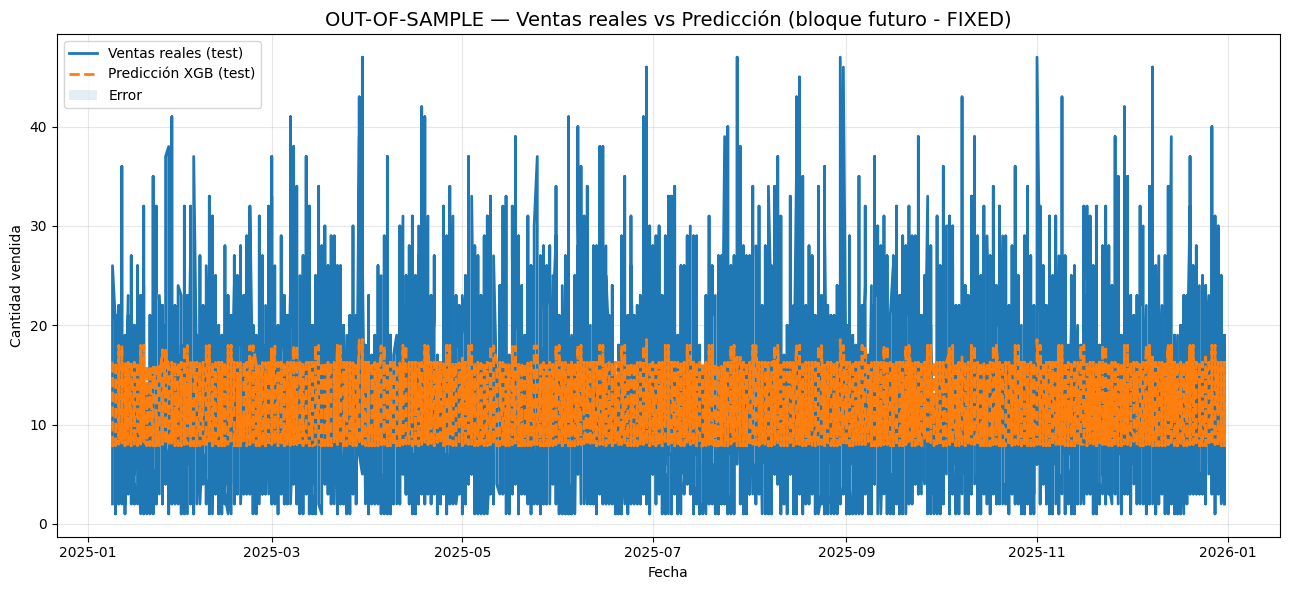

In [ ]:
# === OUT-OF-SAMPLE ROBUSTO (XGBoost) ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pathlib import Path

# 0) Localiza el DataFrame y variables clave
DF = None
for _name in ["df", "data", "df_model"]:
    if _name in globals():
        DF = globals()[_name]
        break
assert DF is not None, "No encuentro el DataFrame (esperaba 'df' o 'data' o 'df_model')."

DATE_COL = "fecha"
TARGET   = "cantidad"
assert DATE_COL in DF.columns, f"Falta columna fecha: {DATE_COL}"
assert TARGET   in DF.columns, f"Falta columna objetivo: {TARGET}"

# 1) Define features (regressors) como "todas menos fecha/objetivo/identificadores obvios"
drop_cols = {DATE_COL, TARGET, "plato", "id_plato", "plato_id"}
regressors = [c for c in DF.columns if c not in drop_cols]

# 2) Orden temporal y split 80/20 (último 20% es "futuro")
df_sorted = DF.sort_values(DATE_COL).reset_index(drop=True).copy()
split_idx = int(len(df_sorted) * 0.80)
train = df_sorted.iloc[:split_idx].copy()
test  = df_sorted.iloc[split_idx:].copy()

X_tr, y_tr = train[regressors], train[TARGET]
X_te, y_te = test[regressors],  test[TARGET]

# 3) Recupera el mejor modelo/params del tuning
#    - Si ya tienes un objeto 'best_model', lo usa tal cual
#    - Si no, intenta crear uno con 'best_params'
#    - Si no, cae a un modelo razonable con hyperparams por defecto (no ideal, pero funcional)
from xgboost import XGBRegressor

_model = None
if "best_model" in globals():
    _model = globals()["best_model"]
elif "best_params" in globals():
    _model = XGBRegressor(
        objective="reg:squarederror",
        tree_method="hist",
        random_state=42,
        n_jobs=-1,
        **best_params
    )
else:
    print("⚠️ No encontré 'best_model' ni 'best_params'. Uso un XGBRegressor base (resultados de muestra).")
    _model = XGBRegressor(
        objective="reg:squarederror",
        tree_method="hist",
        random_state=42,
        n_jobs=-1,
        learning_rate=0.01,
        max_depth=3,
        n_estimators=500,
        subsample=0.8,
        colsample_bytree=1.0
    )

# 4) Entrena SOLO con el bloque de entrenamiento y evalúa en el FUTURO (out-of-sample)
_model.fit(X_tr, y_tr)
y_hat = _model.predict(X_te)

# 5) Métricas out-of-sample
def smape(y_true, y_pred):
    num = np.abs(y_true - y_pred)
    den = (np.abs(y_true) + np.abs(y_pred)) + 1e-9
    return 100.0 * np.mean(2.0 * num / den)

MAE  = mean_absolute_error(y_te, y_hat)
RMSE = np.sqrt(mean_squared_error(y_te, y_hat))
R2   = r2_score(y_te, y_hat)
MAPE = np.mean(100.0 * np.abs(y_te - y_hat) / np.maximum(np.abs(y_te), 1e-9))
sMAPE = smape(y_te.values, y_hat)
ACC = 100.0 - MAPE  # "accuracy" estilo 1-MAPE (referencial en regresión)

print("📊 MÉTRICAS OUT-OF-SAMPLE (bloque futuro)")
print(f"MAE     : {MAE:.4f}")
print(f"RMSE    : {RMSE:.4f}")
print(f"R2      : {R2:.4f}")
print(f"MAPE    : {MAPE:.2f}%")
print(f"sMAPE   : {sMAPE:.2f}%")
print(f"Accuracy: {ACC:.2f}%  (definido como 100 - MAPE)")

# 6) Tabla de comparación y guardado
comparacion = test[[DATE_COL, TARGET]].copy()
comparacion["predicho"]  = y_hat
comparacion["error_abs"] = np.abs(comparacion[TARGET] - comparacion["predicho"])
comparacion["error_%"]   = 100.0 * comparacion["error_abs"] / np.maximum(np.abs(comparacion[TARGET]), 1e-9)

out_dir = Path("data/forecast_output")
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "comparacion_real_predicho_xgb_OUTSAMPLE.csv"
comparacion.to_csv(out_path, index=False, encoding="utf-8")
print(f"✅ Evidencia guardada en: {out_path}")

# 7) Gráfico representativo (solo periodo de test)
plt.figure(figsize=(13,6))
plt.plot(comparacion[DATE_COL], comparacion[TARGET], label="Ventas reales (test)", linewidth=2)
plt.plot(comparacion[DATE_COL], comparacion["predicho"], label="Predicción XGB (test)", linewidth=2, linestyle="--")
plt.fill_between(
    comparacion[DATE_COL],
    comparacion["predicho"], comparacion[TARGET],
    alpha=0.12, label="Error"
)
plt.title("OUT-OF-SAMPLE — Ventas reales vs Predicción (bloque futuro)", fontsize=14)
plt.xlabel("Fecha"); plt.ylabel("Cantidad vendida")
plt.grid(alpha=0.3); plt.legend()
plt.tight_layout()
plt.show()


# **Entrenamiento final**
Entrenamiento segmentado por plato (XGBOOST POISSON)

In [ ]:
# 1) ¿Cuántas filas por plato?
cnt = df.groupby("plato").size().sort_values(ascending=False)
top_candidates = cnt[cnt >= 350].index.tolist()   # umbral sugerido

# 2) ¿El conteo se comporta como conteo? (dispersión > 1 sugiere Poisson)
import numpy as np
dispersion = (
    df.groupby("plato")["cantidad"]
      .apply(lambda s: np.var(s, ddof=1) / (np.mean(s) + 1e-9))
      .sort_values(ascending=False)
)
poisson_ok = dispersion[dispersion > 1.0].index.tolist()

# Intersección: platos con datos suficientes y sobre-dispersión
poisson_segments = list(set(top_candidates).intersection(set(poisson_ok)))
print("Platos para modelo especializado (Poisson):", poisson_segments[:10])
print("Resto: modelo global")


Platos para modelo especializado (Poisson): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Resto: modelo global


In [ ]:
import xgboost as xgb
from tqdm import tqdm

DATE_COL = "fecha"
PLATO_COL = "plato"
TARGET_COL = "cantidad"

# Variables predictoras (ajusta según tu dataset final)
regressors = [c for c in df.columns if c not in [DATE_COL, PLATO_COL, TARGET_COL]]

models_poisson = {}
results_poisson = []

for seg in tqdm(poisson_segments, desc="Entrenando modelos Poisson por plato"):
    g = df[df[PLATO_COL] == seg].copy()
    if len(g) < 250:
        continue

    g = g.sort_values(DATE_COL).reset_index(drop=True)

    # Split temporal: 80% train, 20% test
    split_idx = int(len(g) * 0.8)
    X_tr, X_te = g.iloc[:split_idx][regressors], g.iloc[split_idx:][regressors]
    y_tr, y_te = g.iloc[:split_idx][TARGET_COL], g.iloc[split_idx:][TARGET_COL]

    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dtest  = xgb.DMatrix(X_te, label=y_te)

    params = {
        "objective": "count:poisson",
        "eval_metric": "mae",
        "tree_method": "hist",
        "eta": 0.01,
        "max_depth": 5,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "random_state": 42
    }

    bst = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=600,
        evals=[(dtest, "valid")],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    # Predicciones en test
    y_pred = bst.predict(dtest)
    mae = np.mean(np.abs(y_te - y_pred))
    rmse = np.sqrt(np.mean((y_te - y_pred) ** 2))
    mape = np.mean(np.abs((y_te - y_pred) / np.clip(y_te, 1e-9, None))) * 100
    smape = np.mean(2*np.abs(y_te - y_pred)/(np.abs(y_te)+np.abs(y_pred)+1e-9))*100
    acc = 100 - mape

    results_poisson.append({
        "plato": seg,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape,
        "sMAPE": smape,
        "Accuracy": acc
    })
    models_poisson[seg] = bst

res_poisson_df = pd.DataFrame(results_poisson).sort_values("Accuracy", ascending=False)
display(res_poisson_df)


Entrenando modelos Poisson por plato: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


,plato,MAE,RMSE,MAPE,sMAPE,Accuracy
1,2,0.570061,0.795280,2.611563,2.587435,97.388437
0,1,0.634325,0.841722,2.684377,2.640994,97.315623
3,4,0.498266,0.748172,2.995488,2.927213,97.004512
4,5,0.390160,0.533849,3.108758,3.056304,96.891242
2,3,0.517920,0.824666,3.339597,3.283689,96.660403
5,6,0.334888,0.462344,4.097544,3.707702,95.902456
6,7,0.278546,0.424267,4.328586,4.105006,95.671414
7,8,0.265136,0.394797,5.291157,4.961163,94.708843
8,9,0.218653,0.272778,5.786617,5.421926,94.213383
9,10,0.186707,0.254414,6.430645,6.007816,93.569355


In [ ]:
#PRUEBA IN SAMPLE
val_check = []

for seg, bst in models_poisson.items():
    g = df[df["plato"] == seg].sort_values("fecha")
    split_idx = int(len(g) * 0.8)
    X_train, X_test = g.iloc[:split_idx][regressors], g.iloc[split_idx:][regressors]
    y_train, y_test = g.iloc[:split_idx]["cantidad"], g.iloc[split_idx:]["cantidad"]

    dtrain = xgb.DMatrix(X_train)
    dtest  = xgb.DMatrix(X_test)

    # Predicciones en train (in-sample)
    y_pred_train = bst.predict(dtrain)
    y_pred_test  = bst.predict(dtest)

    def smape(y_true, y_pred):
        return np.mean(2*np.abs(y_true - y_pred) / (np.abs(y_true)+np.abs(y_pred)+1e-9))*100

    smape_train = smape(y_train, y_pred_train)
    smape_test  = smape(y_test,  y_pred_test)

    val_check.append({
        "plato": seg,
        "sMAPE_train": smape_train,
        "sMAPE_test": smape_test,
        "gap": smape_test - smape_train
    })

pd.DataFrame(val_check).sort_values("gap", ascending=False)


,plato,sMAPE_train,sMAPE_test,gap
9,10,5.295733,6.007816,0.712083
7,8,4.414854,4.961163,0.546309
8,9,4.920795,5.421926,0.501131
5,6,3.298366,3.707702,0.409336
2,3,2.948892,3.283689,0.334797
3,4,2.622710,2.927213,0.304503
0,1,2.532063,2.640994,0.108931
6,7,4.043315,4.105006,0.061691
1,2,2.601007,2.587435,-0.013572
4,5,3.161202,3.056304,-0.104898


📊 Validación de generalización por plato:


,plato,sMAPE_train,sMAPE_test,gap,generaliza_bien
4,5,3.161202,3.056304,-0.104898,Sí
1,2,2.601007,2.587435,-0.013572,Sí
6,7,4.043315,4.105006,0.061691,Sí
0,1,2.532063,2.640994,0.108931,Sí
3,4,2.622710,2.927213,0.304503,Sí
2,3,2.948892,3.283689,0.334797,Sí
5,6,3.298366,3.707702,0.409336,Sí
8,9,4.920795,5.421926,0.501131,Sí
7,8,4.414854,4.961163,0.546309,Sí
9,10,5.295733,6.007816,0.712083,Sí


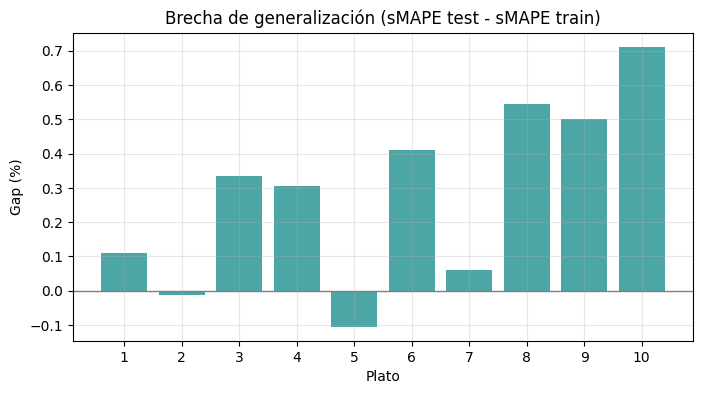

In [ ]:
# --- Evidencias de estabilidad ---
val_df = pd.DataFrame(val_check)
val_df["generaliza_bien"] = np.where(val_df["gap"].abs() <= 1.0, "Sí", "Posible riesgo")

print("📊 Validación de generalización por plato:")
display(val_df.sort_values("gap", ascending=True))

plt.figure(figsize=(8,4))
plt.bar(val_df["plato"].astype(str), val_df["gap"], color="teal", alpha=0.7)
plt.axhline(0, color="gray", linewidth=1)
plt.title("Brecha de generalización (sMAPE test - sMAPE train)")
plt.xlabel("Plato")
plt.ylabel("Gap (%)")
plt.grid(alpha=0.3)
plt.show()


In [ ]:
df_check = df.sort_values("fecha")
is_sorted = df_check["fecha"].is_monotonic_increasing
print("¿Está ordenado cronológicamente?", is_sorted)


¿Está ordenado cronológicamente? True


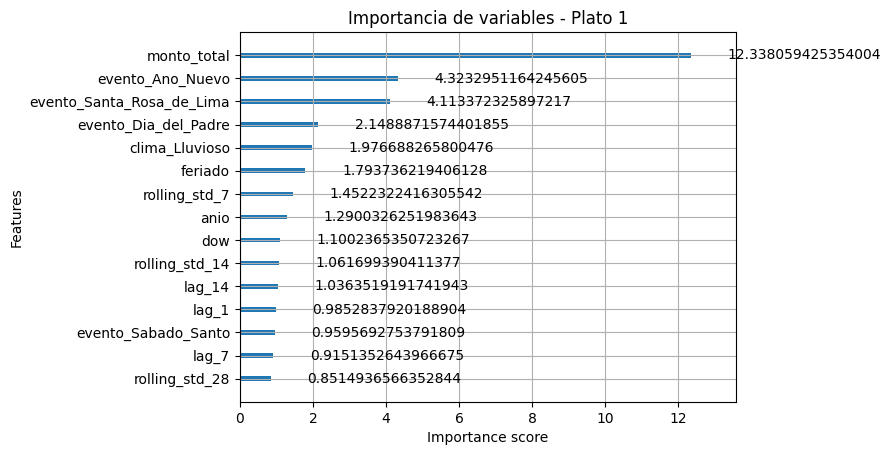

In [ ]:
import xgboost as xgb
from xgboost import plot_importance

seg = 1
g = df[df["plato"] == seg].copy().sort_values("fecha")

dall = xgb.DMatrix(g[regressors])
bst = models_poisson[seg]["booster"] if isinstance(models_poisson[seg], dict) else models_poisson[seg]

# Importancias
xgb.plot_importance(bst, max_num_features=15, importance_type="gain")
plt.title(f"Importancia de variables - Plato {seg}")
plt.show()


In [ ]:
df.groupby("plato")["cantidad"].agg(["min","max","mean","std"])


,min,max,mean,std
plato,,,,
1,5.0,56.0,24.451233,7.516434
2,4.0,47.0,21.783632,6.760567
3,4.0,43.0,16.348094,5.665614
4,3.0,45.0,19.058296,5.936755
5,2.0,31.0,13.502803,4.806869
6,1.0,31.0,10.889574,4.099112
7,1.0,23.0,8.150869,3.351166
8,1.0,19.0,6.812921,3.023489
9,1.0,22.0,5.577904,2.649877


In [ ]:
for seg in poisson_segments[:3]:
    g = df[df["plato"] == seg].sort_values("fecha")
    split_idx = int(len(g) * 0.8)
    print(seg, "Test inicia en:", g.iloc[split_idx]["fecha"])


1 Test inicia en: 2025-01-09 00:00:00
2 Test inicia en: 2025-01-09 00:00:00
3 Test inicia en: 2025-01-09 00:00:00


In [ ]:
from sklearn.metrics import mean_absolute_error

seg = 1
g = df[df["plato"] == seg].sort_values("fecha").reset_index(drop=True)

# Usa los últimos 30 días como pseudo-futuro
X_train, y_train = g.iloc[:-30][regressors], g.iloc[:-30]["cantidad"]
X_future, y_future = g.iloc[-30:][regressors], g.iloc[-30:]["cantidad"]

dtrain = xgb.DMatrix(X_train, label=y_train)
dfuture = xgb.DMatrix(X_future, label=y_future)

bst = models_poisson[seg]["booster"] if isinstance(models_poisson[seg], dict) else models_poisson[seg]

y_pred_future = bst.predict(dfuture)
mae_future = mean_absolute_error(y_future, y_pred_future)
print(f"Plato {seg} — MAE futuro (últimos 30 días): {mae_future:.3f}")


Plato 1 — MAE futuro (últimos 30 días): 0.639
